# ISLR-Python: Applied 9

- [Load College Dataset](#Load-College-Dataset)
- [A. Split Data into Train and Test Sets](#A.-Split-Data-into-Train-and-Test-Sets)
- [B. Fit Least Squares Model](#B.-Fit-Least-Squares-Model)
- [C. Fit Ridge Regression Model](#C.-Fit-Ridge-Regression-Model)
- [D. Fit Lasso Model](#D.-Fit-Lasso-Model)
- [E. Fit a PCR Model](#E.-Fit a PCR Model)
- [F. Fit a PLS Model](#F.-Fit a PLS Model)
- [G. Comment on Models](#G.-Comment-on-Models)

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from operator import itemgetter

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## Load College Dataset

In [2]:
# Load the college data set
df = pd.read_csv('../../../data/College.csv', index_col=0)

In [3]:
# confirm non NaNs and print head()
print(df.isnull().any().any())
df.head()

False


,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [4]:
# we have one column which is categorical 'Private' so convert 
dummy = pd.get_dummies(df.Private, prefix='Private')

In [5]:
# Only need the yes
df.Private = dummy.Private_Yes

In [6]:
df.head(3)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54


## Split Data into Train and Test Sets

In [46]:
# set random seed for reproducible results
np.random.seed(0)

# construct randomly chosen train set roughly 50/50 split
train = np.random.choice([True,False], size=len(df))
df_train = df[train]
df_test = df[~train]

## Fit Least Squares Model

In [47]:
# Fit a least squares model to predict the number of recieved apps as function of all the other features
y_train = df_train['Apps']
features = list(df)
features.remove('Apps')
X_train = df_train[features]

# Fit model, report params
lm = sm.OLS(y_train,sm.add_constant(X_train)).fit()
lm.params

# compute MSE
y_predicted = lm.predict(sm.add_constant(df_test[features]))

LS_MSE = np.mean((df_test.Apps.values-y_predicted)**2)
print("The Least Squares Test MSE = ", LS_MSE)

The Least Squares Test MSE =  1848054.14978


## Fit Ridge Regression Model

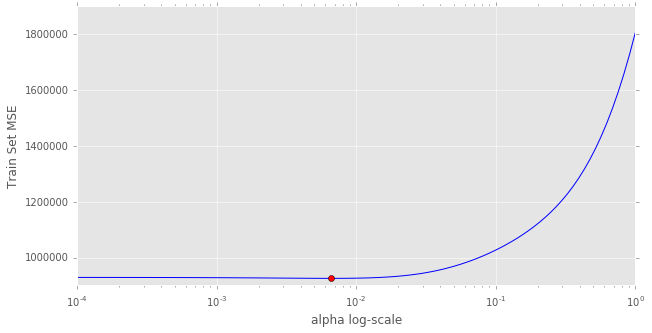

In [9]:
# For ridge regression we will fit ridge models for a range of alphas and select the model with the lowest
# training error rate. Using this optimal alpha we will then predict number of applications and compare
# with the test_set.

# Fit ridge regression over a range of possible alphas
alphas = np.logspace(-4, 0, 100)
# Build estimator
ridge_cv = RidgeCV(alphas = alphas, normalize=True, store_cv_values=True)
# Fit model
results = ridge_cv.fit(X_train.values, y_train.values)

# the results contains a np array [num_samples,num_alphas] a form of LOOCV was performed so 
# the mean(axis=0) is the average MSE for a given alpha
cvs = np.mean(results.cv_values_, axis=0)
# get the minimum error rate and get the optimum alpha
min_cvs = np.min(cvs)
min_alpha = results.alpha_

# Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas,np.mean(results.cv_values_,axis=0), color='b')
ax.plot(min_alpha, min_cvs, color='r', marker='o',)
ax.set_xscale('log')
ax.set_xlabel('alpha log-scale');
ax.set_ylabel('Train Set MSE');

In [10]:
# Get the ridge models predictions on the test set
ridge_predicted = results.predict(df_test[features].values)

# Get the MSE of the Ridges predictions
Ridge_MSE = np.mean((df_test.Apps.values-ridge_predicted)**2)
print("The Ridge Model Test MSE = ", Ridge_MSE, '\n')

print(pd.Series(data = np.hstack([results.intercept_,results.coef_]), index=['Intercept'] + features))

The Ridge Model Test MSE =  1953825.65345 

Intercept     -1062.694072
Private        -684.649474
Accept            1.058455
Enroll            0.334379
Top10perc        38.852495
Top25perc        -9.697783
F.Undergrad       0.005961
P.Undergrad       0.055038
Outstate         -0.024309
Room.Board        0.177457
Books             0.281210
Personal         -0.029562
PhD              -4.390837
Terminal         -4.765855
S.F.Ratio        19.370603
perc.alumni      -5.691326
Expend            0.062184
Grad.Rate        11.416957
dtype: float64


## Fit Lasso Model

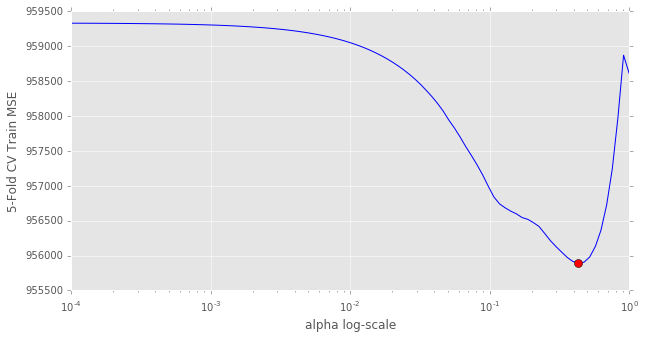

In [11]:
# Use LassoCV to perform 5-fold cross validation to determine optimal alpha
lasso_cv = LassoCV(alphas = np.logspace(-4,0,100), normalize=True, cv=5, max_iter=100000)
lasso_cv.fit(X_train.values, y_train.values)

# The mse estimates are the mean aross folds (cols)
mses = np.mean(lasso_cv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lasso_cv.alphas_,mses, color='b');
ax.plot(lasso_cv.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('5-Fold CV Train MSE');

In [12]:
# Get the lasso model predictions on the test set
lasso_predicted = lasso_cv.predict(df_test[features].values)

# Get the MSE of the lasso predictions
Lasso_MSE = np.mean((df_test.Apps.values-lasso_predicted)**2)
print("The Lasso Model Test MSE = ", Lasso_MSE,'\n')
print('Alpha = ', lasso_cv.alpha_,'\n')
print(pd.Series(data = np.hstack([lasso_cv.intercept_,lasso_cv.coef_]), index=['Intercept'] + features))

The Lasso Model Test MSE =  1860777.35866 

Alpha =  0.432876128108 

Intercept     -1006.260175
Private        -671.472978
Accept            1.123507
Enroll            0.195411
Top10perc        35.843090
Top25perc        -6.979835
F.Undergrad       0.002698
P.Undergrad       0.048355
Outstate         -0.021418
Room.Board        0.158239
Books             0.223854
Personal         -0.008984
PhD              -3.480322
Terminal         -4.468332
S.F.Ratio        16.709474
perc.alumni      -4.605209
Expend            0.058739
Grad.Rate         9.534166
dtype: float64


## Fit a PCR Model

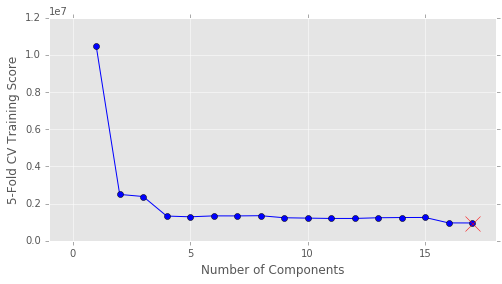

In [53]:
# We will now fit a pcr model

# list for holding the cv scores
scores = []

# We will vary the number of components from 1 component to a maximum of all features (equivalent to LS)
num_components = np.arange(1,len(features)+1)
num_samples = X_train.shape[0]

for n in num_components:
    # construct PCA obj with n_components
    pca = PCA(n_components=n)
    
    # apply scaling, PCA, and Linear Regression in a pipeline
    pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('linear_regression', LinearRegression())])
    
    # Fit data and append cv score
    pipeline.fit(X_train.values,y_train.values)
    scores.append(-np.mean(cross_val_score(pipeline, X_train.values, y_train.values, 
                                           scoring='mean_squared_error', cv=5)))

# get the min cv score
min_index, min_score = min(enumerate(scores), key = itemgetter(1))
    
# Plot CV scores across number of PCs   
fig, ax = plt.subplots(figsize=(8,4))
# Plot the minimum cv score and the number of PCs that give that score
ax.plot(num_components,scores, marker='o', color='b');
ax.plot(min_index+1, min_score, marker='x', color='r', markersize = 15);
ax.set_xlabel('Number of Components');
ax.set_ylabel('5-Fold CV Training Score');
ax.set_xlim(xmin=-1);

So the minimum score is when all 17 features are used. If all features are used as the number of components, PCR is equivalent to least squares, so we will get the same Test MSE as least squares.

## Fit a PLS Model

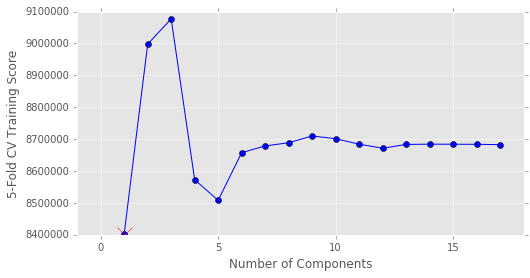

In [57]:
# list to hold cv scores
pls_scores = []

# Get number of components and num samples of training data
num_components = list(np.arange(1,X_train.values.shape[1]+1))
num_samples = X_train.values.shape[0]

for n in num_components:
    # construct PLS obj with n_components
    pls = PLSRegression(n_components=n, scale=True)

    pls_scores.append(-np.mean(cross_val_score(pls, X_train.values, y_train.values, 
                                           scoring='mean_squared_error', cv=5)))   
# get the min cv score
min_index, min_score = min(enumerate(pls_scores), key = itemgetter(1))

# Plot CV scores across number of components 
fig, ax = plt.subplots(figsize=(8,4))

# Plot the minimum cv score and the number of components that give that score
ax.plot(num_components,pls_scores, marker='o', color='b');
ax.plot(min_index+1, min_score, marker='x', color='r', markersize = 15);
ax.set_xlabel('Number of Components');
ax.set_ylabel('5-Fold CV Training Score');
ax.set_xlim(xmin=-1);

So PLS selects an 1 component model.

In [52]:
# get the PLS predictions for the 1 component model

# Set the number of components to 1 and call predict method of PLS Regression in our pipeline
pls = PLSRegression(n_components=1, scale=True)
    
# Fit data and append cv score
pls.fit(X_train.values,y_train.values) 

y_predict=pls.predict(df_test[features].values)

MSE = np.mean((df_test.Apps.values-y_predict)**2)
print(MSE)

20226275.9644


## G. Comment on Models

All of the models perform about the same with the exception of PLS which performs worse. Recall that what all these methods attempt to do is to regulate the variance of the model either by controlling the sizes of feature coeffecients or setting some to zero. The idea is that with many features, we have a higher risk of overfitting the data and the model's variance increases so that it performs poorly on test data. Why have these methods not helped on the college dataset? In chapter three the text explored potential problems that can occur in fitting linear models. The first problem was **non-linearity of the data**. We can see if that is occuring here by looking at a plot of the residuals. 

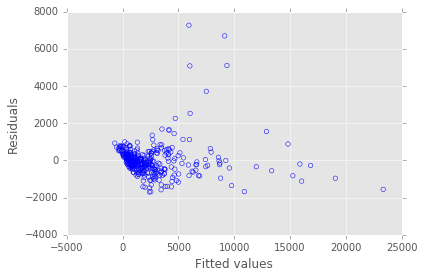

In [62]:
# Plot residuals to inspect data for nonlinearity
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(lm.fittedvalues.values, lm.resid.values, facecolors='none', edgecolors='b');
ax.set_xlabel('Fitted values');
ax.set_ylabel('Residuals');

From this graph it is clear there is a strong pattern in the residuals for fitted values below 5000. A negative slope for this cloud indicates that as the number of predicted apps increases we have larger residuals. This is a good indication of non-linearity in the college data set. We can also see large outliers. 